In [ ]:
from google.colab import drive
drive.mount('/content/drive')
MY_DIR_AUDIOFILES='/content/drive/My Drive/Urdu/Test Dataset/'
MY_DIR_TRANSCRIPTS='/content/drive/My Drive/Urdu/Transcript.txt'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd

Here I'm making a list of all audio paths to make the dataset.

In [ ]:
path=[MY_DIR_AUDIOFILES+str(x)+'.wav' for x in range(1,170) ]

Audio File Path created.

In [ ]:
path[0]

'/content/drive/My Drive/NLPA7/Test Dataset/1.wav'

Reading Transcript file and storing it in an array.

In [ ]:
transcript = open(MY_DIR_TRANSCRIPTS, 'r', encoding="utf8").read().split('\n')
print(transcript[0])

جی سر میں ڈیٹیلز چیک کرتا ہوں کائنڈلی ویٹ کیجیے گا


In [ ]:
transcript[168]

'مزید ویٹ کیجیے گا'

Removing empty lines.


In [ ]:
transcript=[i for i in transcript if i!='']
len(transcript)

169

speech_file_to_array_fn <-- this function makes a dictionary which has all the example stored in it.
Each example is also in a dictionary.

In [ ]:
import librosa
def speech_file_to_array_fn(batch):
    myDataX={}
    for i in range(1,169):
      exampleX={}
      speech_array, sampling_rate = librosa.load(path[i], sr=16000)
      exampleX['Example']=i
      exampleX['Speech Array']=speech_array
      exampleX['Sampling Rate']=sampling_rate
      exampleX['Transcript']=transcript[i]
      myDataX[i]=exampleX
    return myDataX
completeDataSet=speech_file_to_array_fn(dataSet)

In [ ]:
completeDataSet[1]

{'Example': 1,
 'Sampling Rate': 16000,
 'Speech Array': array([ 0.00018311,  0.00018311,  0.        , ..., -0.00015259,
        -0.00024414, -0.00012207], dtype=float32),
 'Transcript': 'اسلام علیکم کر رہا ہوں جی فرمائے میں آپکی کیا مدد کر سکتا ہوں'}

Splitting the data into Training and Validatiuon set.

In [ ]:
#Guideline said we have to split it in 80% and 40% ration so i did 80/20 as it probably was a typo
Train=0.8*len(completeDataSet)
trainDataSet={}
validationDataSet={}
cX=1
for i in range(1,len(completeDataSet)+1):
  if i<=Train:
    trainDataSet[i]=completeDataSet[i]
  else:
    validationDataSet[cX]=completeDataSet[i]
    cX+=1

In [ ]:
trainDataSet[1]

{'Example': 1,
 'Sampling Rate': 16000,
 'Speech Array': array([ 0.00018311,  0.00018311,  0.        , ..., -0.00015259,
        -0.00024414, -0.00012207], dtype=float32),
 'Transcript': 'اسلام علیکم کر رہا ہوں جی فرمائے میں آپکی کیا مدد کر سکتا ہوں'}

In [ ]:
validationDataSet[34]

{'Example': 168,
 'Sampling Rate': 16000,
 'Speech Array': array([0.00061035, 0.0012207 , 0.00161743, ..., 0.00164795, 0.00213623,
        0.00137329], dtype=float32),
 'Transcript': 'مزید ویٹ کیجیے گا'}

Below I'm visualizing the trainDataSet[34]

'جو سروس آپکی وہ پروپر ورکنگ کر رہی ہے نا ہاں جی'

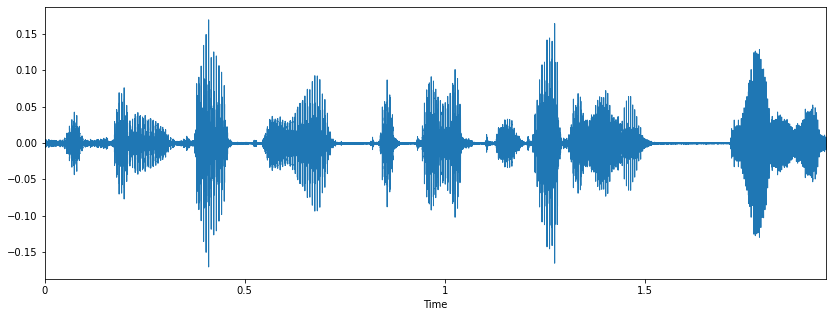

In [ ]:
import matplotlib.pyplot as plt
import librosa.display
ex=trainDataSet[34]
plt.figure(figsize=(14, 5))
librosa.display.waveplot(ex['Speech Array'])
ex['Transcript']

'جو سروس آپکی وہ پروپر ورکنگ کر رہی ہے نا ہاں جی'

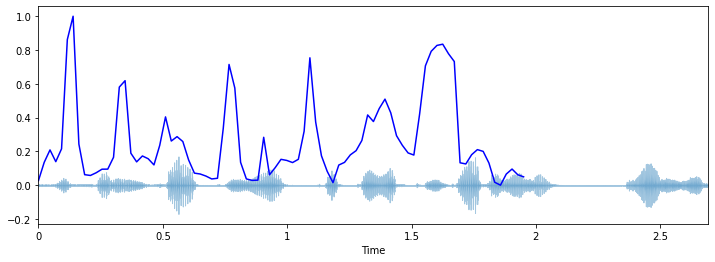

In [ ]:
import sklearn
signal=ex['Speech Array']
sr = ex['Sampling Rate']
spectral_centroids = librosa.feature.spectral_centroid(signal, sr=sr)[0]
spectral_centroids.shape
(775,)

# Computing the time variable for visualization
plt.figure(figsize=(12, 4))
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)

# Normalising the spectral centroid for visualisation
def normalize(signal, axis=0):
    return sklearn.preprocessing.minmax_scale(signal, axis=axis)
#Plotting the Spectral Centroid along the waveform
librosa.display.waveplot(signal, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_centroids), color='b')
ex['Transcript']

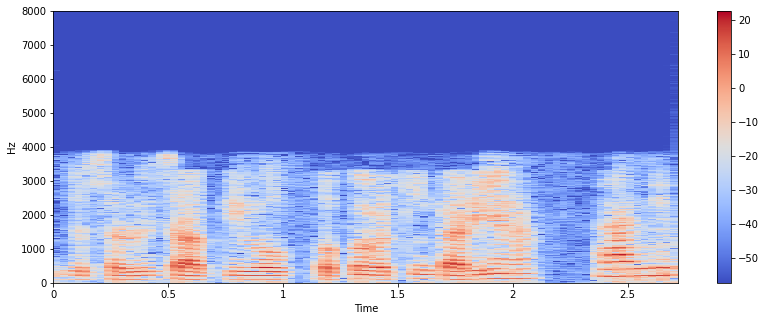

In [ ]:
signal=ex['Speech Array']
S = librosa.stft(signal)
Sdb = librosa.amplitude_to_db(abs(S))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Sdb, sr=sampling_rate, x_axis='time', y_axis='hz')
plt.colorbar()

Defining the model and training it


In [ ]:
!pip install transformers==4.4.0
from transformers import Wav2Vec2CTCTokenizer

tokenizer = Wav2Vec2CTCTokenizer("./vocab.json", unk_token="[UNK]", pad_token="[PAD]", word_delimiter_token="|")
from transformers import Wav2Vec2FeatureExtractor

feature_extractor = Wav2Vec2FeatureExtractor(feature_size=1, sampling_rate=16000, padding_value=0.0, do_normalize=True, return_attention_mask=True)
from transformers import Wav2Vec2Processor

processor = Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)
import torch

from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union

@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    Args:
        processor (:class:`~transformers.Wav2Vec2Processor`)
            The processor used for proccessing the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
        max_length (:obj:`int`, `optional`):
            Maximum length of the ``input_values`` of the returned list and optionally padding length (see above).
        max_length_labels (:obj:`int`, `optional`):
            Maximum length of the ``labels`` returned list and optionally padding length (see above).
        pad_to_multiple_of (:obj:`int`, `optional`):
            If set will pad the sequence to a multiple of the provided value.
            This is especially useful to enable the use of Tensor Cores on NVIDIA hardware with compute capability >=
            7.5 (Volta).
    """

    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True
    max_length: Optional[int] = None
    max_length_labels: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    pad_to_multiple_of_labels: Optional[int] = None

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lenghts and need
        # different padding methods
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )
        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                max_length=self.max_length_labels,
                pad_to_multiple_of=self.pad_to_multiple_of_labels,
                return_tensors="pt",
            )

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        batch["labels"] = labels

        return batch

     |████████████████████████████████| 2.1MB 4.0MB/s 
     |████████████████████████████████| 901kB 33.2MB/s 
     |████████████████████████████████| 3.3MB 10.0MB/s 


FileNotFoundError: ignored

In [ ]:
wer_metric = load_metric("wer")

NameError: ignored